# MNIST - Advanced
This notebook is intended to explain the additional layers added to the simple model. This solution was adapted from the [Deep MNIST for Experts](https://www.tensorflow.org/get_started/mnist/pros) tutorial on the TensorFlow website. This type of model is known as a convolutional neural network. Parts of this workbook were taken from the Jupyter notebook on MNIST for beginners. Before getting started, import any libraries that may be required.

In [1]:
# Import tensorflow and MNIST.
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# Efficiently deals with numerical multi-dimensional arrays.
import numpy as np

# matplotlib is a plotting library. pyplot is its easy-to-use module.
import matplotlib.pyplot as plt

### Load the data
Load the MNIST data set from TensorFlow in the same way as we did in the beginner notebook.

In [2]:
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Define the model

#### Simple model
The advanced model is based on the simple model we created in the beginner notebook. Therefore, we'll recreate this simple model below. The only difference is that we don't create the softmax neuron just yet.

In [3]:
# Create a placeholder node for pixels of flattened image.
x = tf.placeholder(tf.float32, [None, 784], name='x')

# Create the weight and bias as variables so that their values can be adjusted by tensorflow.
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

#### Helper functions
Here we will define a number of helper functions that will be used later in the notebook to create the TensorFlow model. The first function will initialise weights with a small amount of noise for symmetry breaking and to prevent 0 gradients. With standard deviation, a value is morely to be closer to 0 than to, in this case, 0.1 or -0.1.

In [4]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

The next function will initialise biases with a slightly positive initial bias to avoid "dead neurons" since ReLU neurons will be used. A dead neuron is one that will never be adjusted. ReLU (rectified linear unit) neurons are used as activation function in deep learning networks. They are defined as f(x)=max(0,x) where x is the input.

In [5]:
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

The next function will setup convolutional layers. Convolutional layers in a neural network are connectivity pattern between neurons inspired by the visual cortex. These have shown to be successful in analyzing visual imagery. In maths a convolution is an operation on two functions that produce a third. These convolutions will use a stride of one and are zero padded so that the output is the same size as the input.

In [6]:
def conv2d(x, W):
    # In this case our two functions are x and W.
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

The last function will initialise pooling. The pooling is plain old max pooling over 2x2 blocks. It is common to insert a pooling layer between successive convolution layers in a convolutional neural network architecture. Its function is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network, and hence to also control overfitting.

In [7]:
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

#### 1) First convolutional layer
This convolution will compute 32 features for each 5x5 patch. A feature is an individual measurable property or characteristic of a phenomenon being observed, usually numeric. Its weight tensor will have a shape of [5, 5, 1, 32]. The first two dimensions are the patch size, the next is the number of input channels, and the last is the number of output channels.

In [8]:
# The first two dimensions are the patch size.
# The next is the number of input channels.
# The last is the number of output channels.
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

# First reshape x to a 4d tensor:
# - second and third dimensions correspond to image width and height
# - final dimension corresponding to the number of color channels.
x_image = tf.reshape(x, [-1, 28, 28, 1])

# Convolve x_image with the weight tensor.
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

#### 2) Second convolutional layer
Add a second convolution later.

In [9]:
# This layer will have 64 features for each 5x5 patch.
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

#### 3) Densely connected layer
The image size has been reduced to 7x7. Now add a fully connected layer with 1024 neurons to allow processing on the entire image. Neurons in a fully connected layer have full connections to all activations in the previous layer.

In [10]:
# Reshape the tensor from the pooling layer into a batch of vectors.
# multiply by a weight matrix.
# Add a bias.
# Apply a ReLU.
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

#### 4) Dropout
To reduce overfitting, we will apply dropout before the readout layer. The idea of the dropout layer is to randomly drop units, along with their connections, from the neural network during training. This prevents units from co-adapting too much.

In [11]:
# Create a placeholder for the probability that a neuron's output is kept during dropout. 
# This allows us to turn dropout on during training, and turn it off during testing.
# TensorFlow's tf.nn.dropout op automatically handles scaling neuron outputs in addition to masking them.
# Therefore, dropout just works without any additional scaling.
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#### 5) Readout layer
In this layer we define the neuron in the network that should be executed.

In [12]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.add(tf.matmul(h_fc1_drop, W_fc2), b_fc2, name='y_conv')

### Evaluating the model (Part 1)
The neurons used to evaluate the model accuracy remain mostly unchanged from the basic version. The only difference is that we replaced the `y` neuron with `y_conv`.

In [13]:
# Placeholder for the correct label.
y_ = tf.placeholder(tf.float32, [None, 10])

# Get index of highest entry on both the tensors representing the result and correct labels.
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))

# Determine the fraction that are correct.
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Training the model
We'll define two variables to determine the number of times the model should be trained and the learning rate.

In [14]:
training_epochs = 1000
learning_rate = 1e-4

There are also slight changes in training this model from the basic model. We use a different cost function called `softmax_cross_entropy_with_logits`. We also use the AdamOptimiser instead of the GradientDescentOptimiser. The advantage of Adam over Gradient Descent is that it uses moving averages of the parameters which allows it to use a larger effective step size. The algorithm will converge to this step size without fine tuning. The main down side of Adam is that it requires more computation for each parameter in each training step.

In [15]:
# Implement the cross-entropy function between the target and the softmax activation function applied to the model's prediction.
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

# Minimize cross_entropy using the adam algorithm.
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

The rest of the training process, including starting a TensorFlow session, selecting a sample batch and executing the training step multiple times remains the same as with the basic model. In the interest of time, we only train the model 1000 times in this notebook. Even this can take up to a few minutes. Training the model this many times will lead to a lower accuracy compared to training it say 20000 times.

In [16]:
# Create a tensorflow session in which the model will run and initialize the variables.
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

accuracy_history = np.empty(shape=[1], dtype=float)
loss_history = np.empty(shape=[1], dtype=float)

# Train the model X numnber of times.
for i in range(training_epochs):
    batch_xs, batch_ys = mnist.train.next_batch(50)
    
    # Evaluate the accuracy of the model every 50th iteration.
    if i % 50 == 0:
        # Save accuracy value.
        accuracy_history = np.append(accuracy_history, sess.run(accuracy, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 1.0}))

        # Save loss value.
        loss_history = np.append(loss_history, sess.run(cross_entropy, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 1.0}))
    
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})

### Evaluate the model (Part 2)
We'll plot the accuracy and loss values to get a better sense of how the advanced model is progressing at each training step. The goal has not changed from the basic model. We must try to maximise the accuracy while minimising the loss.

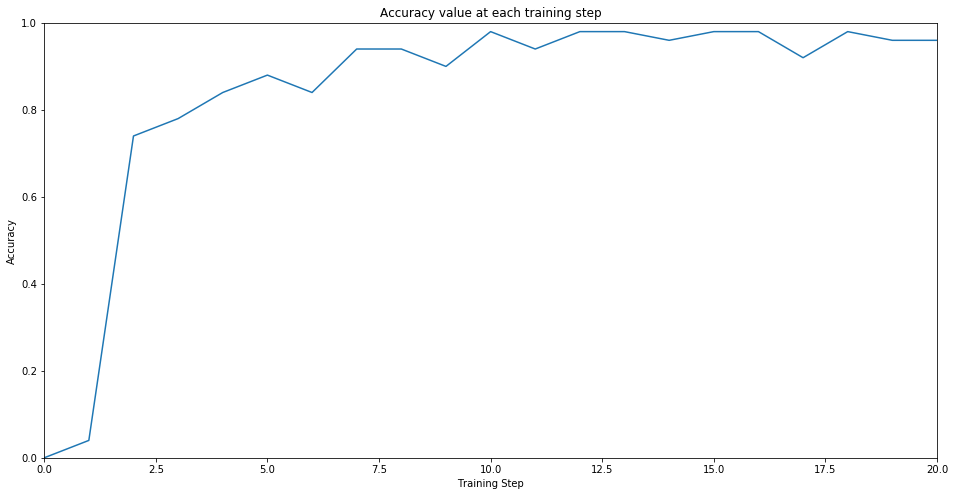

Accuracy: 0.9624


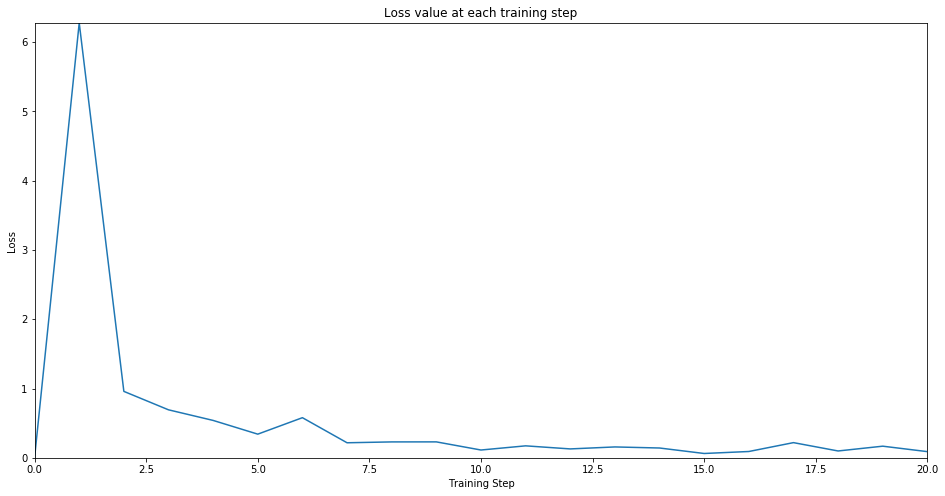

Loss: 0.120715


In [17]:
# This sets the default plot size to be bigger.
plt.rcParams['figure.figsize'] = (16.0, 8.0)

# Adapted from https://aqibsaeed.github.io/2016-07-07-TensorflowLR/
# Plot accuracy values.
plt.plot(range(len(accuracy_history)), accuracy_history)
plt.axis([0, 20, 0, 1])
plt.xlabel('Training Step')
plt.ylabel('Accuracy')
plt.title('Accuracy value at each training step')
plt.show()

# Output the final accuracy for the test set.
print('Accuracy: %s' % (sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})))

# Plot loss values.
plt.plot(range(len(loss_history)), loss_history)
plt.axis([0, 20, 0, np.max(loss_history)])
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Loss value at each training step')
plt.show()

# Output the final loss for the test set.
print('Loss: %s' % (sess.run(cross_entropy, feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})))

Despite training this model relatively few times we still achieve a better accuracy than with the basic model.

### References
+ [Deep MNIST for Experts](https://www.tensorflow.org/get_started/mnist/pros)
+ [Convolutional Neural Networks](http://cs231n.github.io/convolutional-networks/)
+ [Other Techniques](https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results#4d4e495354)